In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
# %matplotlib notebook


import numpy as np
import imageio
from tqdm import tqdm
import pandas as pd


In [2]:
#Import the raw data
raw_data = np.loadtxt('../Data/nbse2.dat')
x = raw_data.T[0]
y = raw_data.T[1]
k = raw_data.T[7]

In [3]:
#The data in pandas
data = pd.DataFrame()
data['x'] = x
data['y'] = y
data['k'] = k

#Restric the axes
zone=data.query(" -2  <= x  <= 2 ").query(" -2.2  <= y  <= 2.2 ")

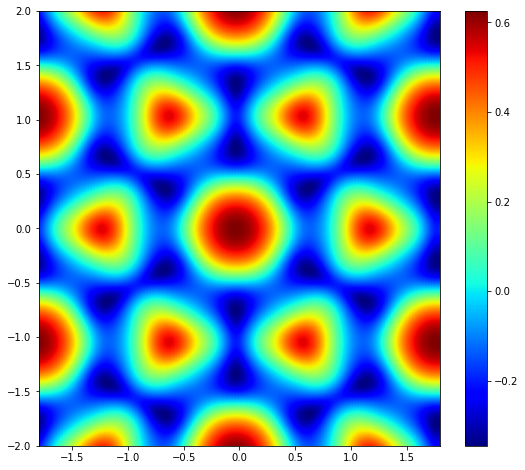

In [4]:
#Plot the data
plt.figure(figsize=(9,8))
plt.scatter(data.x,data.y,c=data.k,cmap="jet")
plt.colorbar()
plt.xlim(-1.8,1.8)
plt.ylim(-2,2)
plt.show()

In [5]:
x = torch.from_numpy(zone[zone.columns[0:2]].values).float()
y = torch.unsqueeze(torch.from_numpy(zone['k'].values), dim=1).float()
x,y= Variable(x), Variable(y)

In [6]:
# Construct the network
net = torch.nn.Sequential(
        torch.nn.Linear(2, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.LeakyReLU(),      
        torch.nn.Linear(100, 1),


    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


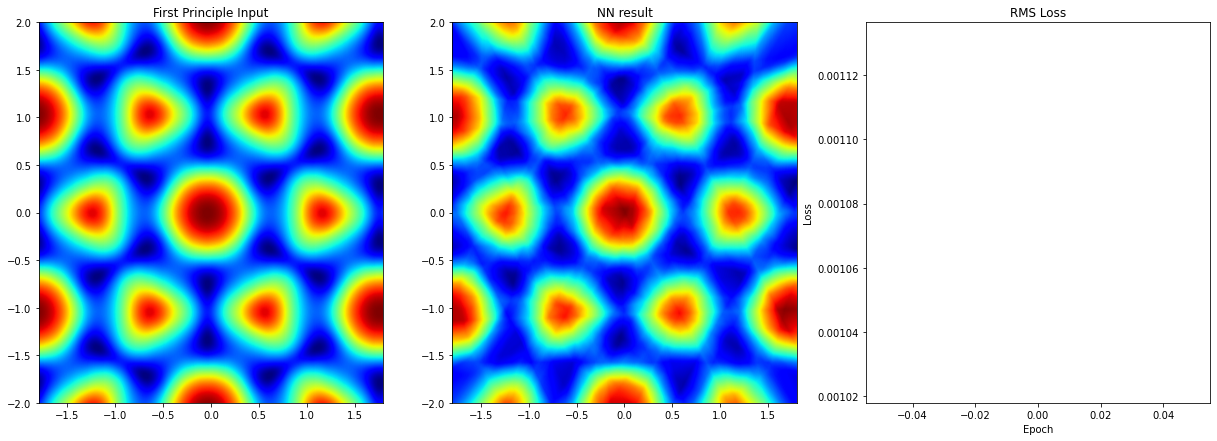

In [8]:
my_images = []
lost=[]
epoch=[]
fig, axs = plt.subplots(1, 3,figsize=(21,7))

# start training
for t in tqdm(range(100)):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if t % 100 == 0:
        # plot and show learning process
        lost.append(loss.data.numpy())
        epoch.append(t)
        
        plt.cla()      
        axs[0].scatter(x[:,0].data.numpy(),x[:,1].data.numpy(),c=y.data.numpy().squeeze(),cmap="jet")
        axs[0].set_xlim(-1.8,1.8)
        axs[0].set_ylim(-2,2)
        axs[0].set_title("First Principle Input")
        axs[1].scatter(x[:,0].data.numpy(),x[:,1].data.numpy(),c=prediction.data.numpy().squeeze(),cmap="jet")
        axs[1].set_xlim(-1.8,1.8)
        axs[1].set_ylim(-2,2)
        axs[1].set_title("NN result")
        axs[2].plot(epoch,lost)
        axs[2].set_title("RMS Loss")
        axs[2].set(xlabel='Epoch', ylabel='Loss')
        


        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)
    
    


# save images as a gif    
imageio.mimsave('./nbse2.gif', my_images, fps=2)